In [1]:
##################################################################################
##### Define all parameters for model tuning
##################################################################################

n_fold = 5
expName = "NT_Site_PredNTS_Classification_DLNN_CORENup_v2_gaussianNoise_valsplit"
outPath = "Results"
foldName = "folds.pickle"

shuffle = True
seed = None

input_data_folder = "Data"
training_data_file = "Training-datasets-PredNTS.txt"
independent_data_file = "independent dataset-PredNTS.txt"

monitor = "val_loss"
valsplit = 0.3

In [2]:
import os 
import pickle
import numpy as np
import pandas as pd

import tensorflow as tf

from sklearn.metrics import roc_auc_score
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_curve, auc, accuracy_score, precision_score, confusion_matrix
from sklearn.metrics import roc_auc_score, matthews_corrcoef

import math

import matplotlib.pyplot as plt

In [3]:
# print(tf.test.is_gpu_available(cuda_only=True))
# physical_devices = tf.config.experimental.list_physical_devices('GPU')
physical_devices = tf.config.list_physical_devices('GPU')
print(physical_devices)
tf.config.experimental.set_memory_growth(physical_devices[0], True)

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [4]:
##################################################################################
##### define all CUSTOM functions
##################################################################################

def one_hot_encode_nt(sequence, char_dict):
    
    seq_encoded = np.zeros((len(sequence),len(char_dict)))
    
    i = 0
    for single_character in sequence:
        if(single_character.upper() in char_dict.keys()):
            seq_encoded[i][char_dict[single_character.upper()]] = 1
            i = i+1
        else:
            raise ValueError('Incorrect character in NT sequence: '+sequence)
    return seq_encoded

In [5]:
##################################################################################
##### Build k-fold functions
##################################################################################

## Build the K-fold from dataset
def build_kfold(features, labels, k=10, shuffle=False, seed=None):
    
    skf = StratifiedKFold(n_splits=k, shuffle=shuffle, random_state=seed)
    kfoldList = []
    for train_index, test_index in skf.split(features, labels):
        X_train, X_test = features[train_index], features[test_index]
        y_train, y_test = labels[train_index], labels[test_index]
        kfoldList.append({
            "X_train": X_train,
            "X_test": X_test,
            "y_train":y_train,
            "y_test":y_test
        })
    return kfoldList

In [6]:
##################################################################################
##### define evaluator functions
##################################################################################

def pred2label(y_pred):
    y_pred = np.round(y_pred).astype(int)
    return y_pred

In [7]:
epochs = 100
batch_size = 16

##################################################################################
##### Function to customize the DLNN architecture with parameters
##################################################################################

def DLNN_CORENup(input_seq_shape = (41, 21),
                 conv_filters_per_layer_1 = 25, kernel_length_1 = 10, conv_strides_1 = 1, ## 1st Convolutional layer parameters
                 max_pool_width_1 = 3, max_pool_stride_1 = 3, ## 1st Maxpool layer parameters
                 lstm_decode_units = 25, ## LSTM layer parameters
                 conv_filters_per_layer_2 = 25,  kernel_length_2 = 5, conv_strides_2 = 1, ## 2nd Convolutional layer parameters
                 max_pool_width_2 = 3, max_pool_stride_2 = 3, ## 2nd Maxpool layer parameters
                 dense_decode_units = 256, ## Dense layer parameters
                 prob = 0.5, learn_rate = 0.0005, 
                 loss = 'binary_crossentropy', metrics = 'accuracy'):
    
    beta = 0.001
    
    ######################################################################################################
    ########  SEQUENCE  ##################################################################################
    ######################################################################################################
    
    input1 = tf.keras.layers.Input(shape=input_seq_shape)

    x1 = tf.keras.layers.Conv1D(conv_filters_per_layer_1, kernel_length_1,
                                strides = conv_strides_1, kernel_regularizer = tf.keras.regularizers.l2(beta), 
                                padding = "same")(input1)
    x1 = tf.keras.layers.Activation('relu')(x1)
    x1 = tf.keras.layers.MaxPool1D(pool_size = max_pool_width_1, strides = max_pool_stride_1)(x1)
    x1 = tf.keras.layers.Dropout(prob)(x1)
    
    x1 = tf.keras.layers.GaussianNoise(stddev=0.1)(x1)

    ## LSTM Path

    x2 = tf.keras.layers.LSTM(lstm_decode_units, return_sequences = True, 
                              kernel_regularizer = tf.keras.regularizers.l2(beta))(x1)
    
    x2 = tf.keras.layers.Dropout(prob)(x2)
    
    x2 = tf.keras.layers.Flatten()(x2)
    
    x2 = tf.keras.layers.GaussianNoise(stddev=0.1)(x2)

    ## Conv Path

    x3 = tf.keras.layers.Conv1D(conv_filters_per_layer_2, kernel_length_2, strides = conv_strides_2, 
                                kernel_regularizer = tf.keras.regularizers.l2(beta), padding = 'same')(x1)
    x3 = tf.keras.layers.Activation('relu')(x3)
    x3 = tf.keras.layers.MaxPooling1D(pool_size = max_pool_width_2, strides = max_pool_stride_2)(x3)
    x3 = tf.keras.layers.Dropout(prob)(x3)
    
    x3 = tf.keras.layers.Flatten()(x3)
    
    x3 = tf.keras.layers.GaussianNoise(stddev=0.1)(x3)
    
    x4 = tf.keras.layers.Concatenate(1)([x2,x3])
    
    ######################################################################################################
    ########  Classifier  ################################################################################
    ######################################################################################################
    
    y = tf.keras.layers.Dense(dense_decode_units, 
                              kernel_regularizer = tf.keras.regularizers.l2(beta), 
                              activation = 'relu')(x4)
    
    y = tf.keras.layers.GaussianNoise(stddev=0.1)(y)
    
    y = tf.keras.layers.Dropout(prob)(y)
    
    y = tf.keras.layers.Dense(1, 
                              kernel_regularizer = tf.keras.regularizers.l2(beta), 
                              activation = 'sigmoid')(y)

    ## Generate Model from input and output
    model = tf.keras.models.Model(inputs=input1, outputs=y)
    
    ## Compile model
    if(metrics != None):
        model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate=learn_rate), loss = loss, metrics = metrics)
    else:
        model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate=learn_rate), loss = loss)

    return model

In [8]:
DLNN_CORENup().summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 41, 21)]     0           []                               
                                                                                                  
 conv1d (Conv1D)                (None, 41, 25)       5275        ['input_1[0][0]']                
                                                                                                  
 activation (Activation)        (None, 41, 25)       0           ['conv1d[0][0]']                 
                                                                                                  
 max_pooling1d (MaxPooling1D)   (None, 13, 25)       0           ['activation[0][0]']             
                                                                                              

# Training

In [9]:
##################################################################################
##### read training file
##################################################################################
train_file_path = os.path.join(input_data_folder, training_data_file)
train_data = pd.read_csv(train_file_path, sep='\t', header=None)
train_data.columns = ['Sequence', 'name', 'id', 'flag', 'label_original', 'type']
train_data.head()

##################################################################################
##### Create dictionary of all characters in the NT sequence 
##################################################################################
all_char_set = set({})
for val in [set(val) for val in train_data['Sequence']]:
    all_char_set = all_char_set.union(val)
all_char_list = list(all_char_set)
all_char_list.sort()
all_char_dict = {}
for i in range(len(all_char_list)):
    all_char_dict[all_char_list[i]] = i
    
##################################################################################
##### Create OHE of sequence
##################################################################################
train_data['OHE_Sequence'] = pd.Series([one_hot_encode_nt(val, all_char_dict) 
                                        for val in train_data["Sequence"]])

##################################################################################
##### Fix the labels
##################################################################################
train_data['label'] = pd.Series([1 if val == 1 else 0 
                                 for val in train_data["label_original"]])

##################################################################################
##### Extract features and labels, create folds
##################################################################################

features = np.array(list(train_data['OHE_Sequence']))
labels = np.array(list(train_data['label']))
labels = labels.reshape((labels.shape[0], 1))

input_seq_shape = features[0].shape

folds = build_kfold(features, labels, k=n_fold, shuffle=shuffle, seed=seed)

## Write the k-fold dataset to file
foldPath = os.path.join(outPath, expName, "{}fold".format(n_fold))
if(not os.path.isdir(foldPath)):
    os.makedirs(foldPath)
pickle.dump(folds, open(os.path.join(foldPath, foldName), "wb"))

In [10]:
##################################################################################
##### For each input file, train model and generate different outputs in a structured folder
##################################################################################

## create the evaluation data structure for all iterations
evaluations = {
    "Fold" : [],
    "Train_Test" : [],
    "Accuracy" : [],
    "Precision": [],
    "TPR": [],
    "FPR": [],
    "TPR_FPR_Thresholds": [],
    "AUC": [],
    "Sensitivity": [],
    "Specificity": [],
    "MCC":[]
}

##################################################################################
##### Train/Test model on all folds, generate evaluations
##################################################################################

## Create and set directory to save model
modelPath = os.path.join(outPath, expName, "{}fold".format(n_fold), "models")
if(not os.path.isdir(modelPath)):
    os.makedirs(modelPath)

    
train_history = []

i = -1
for fold in folds:
    i += 1
    
    print("\nTrain/Test model on Fold #"+str(i)+".")
    
    model = DLNN_CORENup(input_seq_shape = input_seq_shape)
    
    ## Define the model callbacks for early stopping and saving the model. Then train model
    current_model_path = os.path.join(modelPath, "bestModel-fold{}.hdf5".format(i))
    modelCallbacks = [
        tf.keras.callbacks.ModelCheckpoint(current_model_path,
                                           monitor = monitor, verbose = 1, save_best_only = True, 
                                           save_weights_only = False, mode = 'auto', save_freq = 'epoch'),
    ]
    
    # adding random shuffling of the dataset for training purpose
    index_arr = np.arange(fold["X_train"].shape[0])
    index_arr = np.random.permutation(index_arr)
    
    h = model.fit(x = fold["X_train"][index_arr], y = fold["y_train"][index_arr], 
                  batch_size = batch_size, epochs = epochs, 
                  verbose = 1, callbacks = modelCallbacks, 
                  validation_split = valsplit)
    
    train_history.append(h)
    
    model = tf.keras.models.load_model(current_model_path)
    
    ##################################################################################
    ##### Prediction and metrics for TRAIN dataset
    ##################################################################################

    y_pred = model.predict(fold["X_train"])
    label_pred = pred2label(y_pred)
    
    # Compute precision, recall, sensitivity, specifity, mcc
    acc = accuracy_score(fold["y_train"], label_pred)
    prec = precision_score(fold["y_train"],label_pred)
    mcc = matthews_corrcoef(fold["y_train"], label_pred)

    conf = confusion_matrix(fold["y_train"], label_pred)
    tn, fp, fn, tp = conf.ravel()
    sens = tp/(tp+fn)
    spec = tn/(tn+fp)
    
    fpr, tpr, thresholds = roc_curve(fold["y_train"], y_pred)
    auc = roc_auc_score(fold["y_train"], y_pred)
    
    evaluations["Fold"].append(i)
    evaluations["Train_Test"].append("Train")
    evaluations["Accuracy"].append(acc)
    evaluations["Precision"].append(prec)
    evaluations["TPR"].append(tpr)
    evaluations["FPR"].append(fpr)
    evaluations["TPR_FPR_Thresholds"].append(thresholds)
    evaluations["AUC"].append(auc)
    evaluations["Sensitivity"].append(sens)
    evaluations["Specificity"].append(spec)
    evaluations["MCC"].append(mcc)
    
    ##################################################################################
    ##### Prediction and metrics for TEST dataset
    ##################################################################################

    y_pred = model.predict(fold["X_test"])
    label_pred = pred2label(y_pred)
    
    # Compute precision, recall, sensitivity, specifity, mcc
    acc = accuracy_score(fold["y_test"], label_pred)
    prec = precision_score(fold["y_test"],label_pred)
    mcc = matthews_corrcoef(fold["y_test"], label_pred)

    conf = confusion_matrix(fold["y_test"], label_pred)
    tn, fp, fn, tp = conf.ravel()
    sens = tp/(tp+fn)
    spec = tn/(tn+fp)
    
    fpr, tpr, thresholds = roc_curve(fold["y_test"], y_pred)
    auc = roc_auc_score(fold["y_test"], y_pred)
    
    evaluations["Fold"].append(i)
    evaluations["Train_Test"].append("Test")
    evaluations["Accuracy"].append(acc)
    evaluations["Precision"].append(prec)
    evaluations["TPR"].append(tpr)
    evaluations["FPR"].append(fpr)
    evaluations["TPR_FPR_Thresholds"].append(thresholds)
    evaluations["AUC"].append(auc)
    evaluations["Sensitivity"].append(sens)
    evaluations["Specificity"].append(spec)
    evaluations["MCC"].append(mcc)


Train/Test model on Fold #0.
Epoch 1/100
84/84 [==============================] - ETA: 0s - loss: 1.0891 - accuracy: 0.4981
Epoch 1: val_loss improved from inf to 1.03911, saving model to Results\NT_Site_PredNTS_Classification_DLNN_CORENup_v2_gaussianNoise_valsplit\5fold\models\bestModel-fold0.hdf5
84/84 [==============================] - 18s 21ms/step - loss: 1.0891 - accuracy: 0.4981 - val_loss: 1.0391 - val_accuracy: 0.4930
Epoch 2/100
82/84 [============================>.] - ETA: 0s - loss: 1.0208 - accuracy: 0.5389
Epoch 2: val_loss improved from 1.03911 to 0.97277, saving model to Results\NT_Site_PredNTS_Classification_DLNN_CORENup_v2_gaussianNoise_valsplit\5fold\models\bestModel-fold0.hdf5
84/84 [==============================] - 1s 12ms/step - loss: 1.0202 - accuracy: 0.5401 - val_loss: 0.9728 - val_accuracy: 0.6521
Epoch 3/100
84/84 [==============================] - ETA: 0s - loss: 0.9382 - accuracy: 0.6167
Epoch 3: val_loss improved from 0.97277 to 0.87859, saving model to 

Epoch 23/100
80/84 [===========================>..] - ETA: 0s - loss: 0.4294 - accuracy: 0.8609
Epoch 23: val_loss did not improve from 0.61837
84/84 [==============================] - 1s 11ms/step - loss: 0.4307 - accuracy: 0.8582 - val_loss: 0.6290 - val_accuracy: 0.7570
Epoch 24/100
80/84 [===========================>..] - ETA: 0s - loss: 0.4484 - accuracy: 0.8438
Epoch 24: val_loss did not improve from 0.61837
84/84 [==============================] - 1s 11ms/step - loss: 0.4508 - accuracy: 0.8410 - val_loss: 0.6222 - val_accuracy: 0.7448
Epoch 25/100
81/84 [===========================>..] - ETA: 0s - loss: 0.4393 - accuracy: 0.8526
Epoch 25: val_loss did not improve from 0.61837
84/84 [==============================] - 1s 11ms/step - loss: 0.4391 - accuracy: 0.8515 - val_loss: 0.6420 - val_accuracy: 0.7308
Epoch 26/100
84/84 [==============================] - ETA: 0s - loss: 0.3942 - accuracy: 0.8762
Epoch 26: val_loss did not improve from 0.61837
84/84 [===========================

Epoch 51/100
84/84 [==============================] - ETA: 0s - loss: 0.2937 - accuracy: 0.9137
Epoch 51: val_loss did not improve from 0.58123
84/84 [==============================] - 1s 11ms/step - loss: 0.2937 - accuracy: 0.9137 - val_loss: 0.6321 - val_accuracy: 0.7657
Epoch 52/100
79/84 [===========================>..] - ETA: 0s - loss: 0.2898 - accuracy: 0.9051
Epoch 52: val_loss did not improve from 0.58123
84/84 [==============================] - 1s 12ms/step - loss: 0.2859 - accuracy: 0.9070 - val_loss: 0.6457 - val_accuracy: 0.7657
Epoch 53/100
81/84 [===========================>..] - ETA: 0s - loss: 0.3105 - accuracy: 0.9051
Epoch 53: val_loss did not improve from 0.58123
84/84 [==============================] - 1s 13ms/step - loss: 0.3119 - accuracy: 0.9032 - val_loss: 0.5994 - val_accuracy: 0.7640
Epoch 54/100
82/84 [============================>.] - ETA: 0s - loss: 0.2870 - accuracy: 0.9108
Epoch 54: val_loss did not improve from 0.58123
84/84 [===========================

Epoch 81/100
81/84 [===========================>..] - ETA: 0s - loss: 0.2569 - accuracy: 0.9290
Epoch 81: val_loss did not improve from 0.58123
84/84 [==============================] - 1s 13ms/step - loss: 0.2572 - accuracy: 0.9287 - val_loss: 0.6471 - val_accuracy: 0.7710
Epoch 82/100
82/84 [============================>.] - ETA: 0s - loss: 0.2493 - accuracy: 0.9329
Epoch 82: val_loss did not improve from 0.58123
84/84 [==============================] - 1s 13ms/step - loss: 0.2499 - accuracy: 0.9325 - val_loss: 0.6565 - val_accuracy: 0.7710
Epoch 83/100
82/84 [============================>.] - ETA: 0s - loss: 0.2456 - accuracy: 0.9299
Epoch 83: val_loss did not improve from 0.58123
84/84 [==============================] - 1s 13ms/step - loss: 0.2458 - accuracy: 0.9295 - val_loss: 0.6295 - val_accuracy: 0.7692
Epoch 84/100
81/84 [===========================>..] - ETA: 0s - loss: 0.2495 - accuracy: 0.9236
Epoch 84: val_loss did not improve from 0.58123
84/84 [===========================

Epoch 8/100
83/84 [============================>.] - ETA: 0s - loss: 0.6856 - accuracy: 0.7613
Epoch 8: val_loss improved from 0.77301 to 0.75024, saving model to Results\NT_Site_PredNTS_Classification_DLNN_CORENup_v2_gaussianNoise_valsplit\5fold\models\bestModel-fold1.hdf5
84/84 [==============================] - 1s 11ms/step - loss: 0.6846 - accuracy: 0.7614 - val_loss: 0.7502 - val_accuracy: 0.7255
Epoch 9/100
83/84 [============================>.] - ETA: 0s - loss: 0.6514 - accuracy: 0.7605
Epoch 9: val_loss improved from 0.75024 to 0.74592, saving model to Results\NT_Site_PredNTS_Classification_DLNN_CORENup_v2_gaussianNoise_valsplit\5fold\models\bestModel-fold1.hdf5
84/84 [==============================] - 1s 11ms/step - loss: 0.6526 - accuracy: 0.7599 - val_loss: 0.7459 - val_accuracy: 0.7115
Epoch 10/100
80/84 [===========================>..] - ETA: 0s - loss: 0.6286 - accuracy: 0.7852
Epoch 10: val_loss improved from 0.74592 to 0.73747, saving model to Results\NT_Site_PredNTS_C

Epoch 31/100
81/84 [===========================>..] - ETA: 0s - loss: 0.3885 - accuracy: 0.8719
Epoch 31: val_loss did not improve from 0.62732
84/84 [==============================] - 1s 12ms/step - loss: 0.3875 - accuracy: 0.8732 - val_loss: 0.6345 - val_accuracy: 0.7535
Epoch 32/100
83/84 [============================>.] - ETA: 0s - loss: 0.3945 - accuracy: 0.8622
Epoch 32: val_loss improved from 0.62732 to 0.60657, saving model to Results\NT_Site_PredNTS_Classification_DLNN_CORENup_v2_gaussianNoise_valsplit\5fold\models\bestModel-fold1.hdf5
84/84 [==============================] - 1s 15ms/step - loss: 0.3941 - accuracy: 0.8620 - val_loss: 0.6066 - val_accuracy: 0.7517
Epoch 33/100
83/84 [============================>.] - ETA: 0s - loss: 0.3621 - accuracy: 0.8758
Epoch 33: val_loss did not improve from 0.60657
84/84 [==============================] - 1s 14ms/step - loss: 0.3623 - accuracy: 0.8755 - val_loss: 0.6145 - val_accuracy: 0.7587
Epoch 34/100
83/84 [=========================

84/84 [==============================] - 1s 12ms/step - loss: 0.2695 - accuracy: 0.9250 - val_loss: 0.6942 - val_accuracy: 0.7692
Epoch 61/100
84/84 [==============================] - ETA: 0s - loss: 0.2801 - accuracy: 0.9137
Epoch 61: val_loss did not improve from 0.60657
84/84 [==============================] - 1s 11ms/step - loss: 0.2801 - accuracy: 0.9137 - val_loss: 0.6849 - val_accuracy: 0.7640
Epoch 62/100
84/84 [==============================] - ETA: 0s - loss: 0.2903 - accuracy: 0.9130
Epoch 62: val_loss did not improve from 0.60657
84/84 [==============================] - 1s 11ms/step - loss: 0.2903 - accuracy: 0.9130 - val_loss: 0.6412 - val_accuracy: 0.7640
Epoch 63/100
79/84 [===========================>..] - ETA: 0s - loss: 0.2769 - accuracy: 0.9201
Epoch 63: val_loss did not improve from 0.60657
84/84 [==============================] - 1s 10ms/step - loss: 0.2733 - accuracy: 0.9205 - val_loss: 0.6803 - val_accuracy: 0.7710
Epoch 64/100
81/84 [===========================>

84/84 [==============================] - 1s 11ms/step - loss: 0.2620 - accuracy: 0.9227 - val_loss: 0.6557 - val_accuracy: 0.7885
Epoch 91/100
83/84 [============================>.] - ETA: 0s - loss: 0.2422 - accuracy: 0.9375
Epoch 91: val_loss did not improve from 0.60657
84/84 [==============================] - 1s 10ms/step - loss: 0.2417 - accuracy: 0.9377 - val_loss: 0.7660 - val_accuracy: 0.7500
Epoch 92/100
81/84 [===========================>..] - ETA: 0s - loss: 0.2450 - accuracy: 0.9306
Epoch 92: val_loss did not improve from 0.60657
84/84 [==============================] - 1s 11ms/step - loss: 0.2431 - accuracy: 0.9310 - val_loss: 0.6997 - val_accuracy: 0.7745
Epoch 93/100
81/84 [===========================>..] - ETA: 0s - loss: 0.2451 - accuracy: 0.9336
Epoch 93: val_loss did not improve from 0.60657
84/84 [==============================] - 1s 11ms/step - loss: 0.2452 - accuracy: 0.9340 - val_loss: 0.7105 - val_accuracy: 0.7745
Epoch 94/100
80/84 [===========================>

Epoch 15/100
84/84 [==============================] - ETA: 0s - loss: 0.5588 - accuracy: 0.8058
Epoch 15: val_loss improved from 0.64898 to 0.63185, saving model to Results\NT_Site_PredNTS_Classification_DLNN_CORENup_v2_gaussianNoise_valsplit\5fold\models\bestModel-fold2.hdf5
84/84 [==============================] - 1s 12ms/step - loss: 0.5588 - accuracy: 0.8058 - val_loss: 0.6318 - val_accuracy: 0.7622
Epoch 16/100
83/84 [============================>.] - ETA: 0s - loss: 0.5400 - accuracy: 0.8035
Epoch 16: val_loss improved from 0.63185 to 0.63158, saving model to Results\NT_Site_PredNTS_Classification_DLNN_CORENup_v2_gaussianNoise_valsplit\5fold\models\bestModel-fold2.hdf5
84/84 [==============================] - 1s 13ms/step - loss: 0.5402 - accuracy: 0.8036 - val_loss: 0.6316 - val_accuracy: 0.7622
Epoch 17/100
84/84 [==============================] - ETA: 0s - loss: 0.5291 - accuracy: 0.8118
Epoch 17: val_loss did not improve from 0.63158
84/84 [==============================] - 1

Epoch 41/100
83/84 [============================>.] - ETA: 0s - loss: 0.3129 - accuracy: 0.9044
Epoch 41: val_loss did not improve from 0.58734
84/84 [==============================] - 1s 12ms/step - loss: 0.3119 - accuracy: 0.9048 - val_loss: 0.6116 - val_accuracy: 0.7780
Epoch 42/100
83/84 [============================>.] - ETA: 0s - loss: 0.3212 - accuracy: 0.8916
Epoch 42: val_loss did not improve from 0.58734
84/84 [==============================] - 1s 12ms/step - loss: 0.3212 - accuracy: 0.8913 - val_loss: 0.6223 - val_accuracy: 0.7745
Epoch 43/100
80/84 [===========================>..] - ETA: 0s - loss: 0.3522 - accuracy: 0.8797
Epoch 43: val_loss did not improve from 0.58734
84/84 [==============================] - 1s 13ms/step - loss: 0.3550 - accuracy: 0.8786 - val_loss: 0.5905 - val_accuracy: 0.7710
Epoch 44/100
83/84 [============================>.] - ETA: 0s - loss: 0.3279 - accuracy: 0.8916
Epoch 44: val_loss did not improve from 0.58734
84/84 [===========================

84/84 [==============================] - 1s 12ms/step - loss: 0.2579 - accuracy: 0.9310 - val_loss: 0.6498 - val_accuracy: 0.7797
Epoch 71/100
80/84 [===========================>..] - ETA: 0s - loss: 0.2607 - accuracy: 0.9250
Epoch 71: val_loss did not improve from 0.57793
84/84 [==============================] - 1s 11ms/step - loss: 0.2583 - accuracy: 0.9258 - val_loss: 0.6376 - val_accuracy: 0.7920
Epoch 72/100
84/84 [==============================] - ETA: 0s - loss: 0.2869 - accuracy: 0.9100
Epoch 72: val_loss did not improve from 0.57793
84/84 [==============================] - 1s 12ms/step - loss: 0.2869 - accuracy: 0.9100 - val_loss: 0.6076 - val_accuracy: 0.7815
Epoch 73/100
81/84 [===========================>..] - ETA: 0s - loss: 0.2652 - accuracy: 0.9190
Epoch 73: val_loss did not improve from 0.57793
84/84 [==============================] - 1s 12ms/step - loss: 0.2670 - accuracy: 0.9190 - val_loss: 0.6844 - val_accuracy: 0.7570
Epoch 74/100
80/84 [===========================>

84/84 [==============================] - 1s 15ms/step - loss: 0.2333 - accuracy: 0.9385 - val_loss: 0.6893 - val_accuracy: 0.7885

Train/Test model on Fold #3.
Epoch 1/100
83/84 [============================>.] - ETA: 0s - loss: 1.0994 - accuracy: 0.4985
Epoch 1: val_loss improved from inf to 1.04053, saving model to Results\NT_Site_PredNTS_Classification_DLNN_CORENup_v2_gaussianNoise_valsplit\5fold\models\bestModel-fold3.hdf5
84/84 [==============================] - 4s 18ms/step - loss: 1.0993 - accuracy: 0.4978 - val_loss: 1.0405 - val_accuracy: 0.5192
Epoch 2/100
80/84 [===========================>..] - ETA: 0s - loss: 1.0379 - accuracy: 0.5227
Epoch 2: val_loss improved from 1.04053 to 0.98078, saving model to Results\NT_Site_PredNTS_Classification_DLNN_CORENup_v2_gaussianNoise_valsplit\5fold\models\bestModel-fold3.hdf5
84/84 [==============================] - 1s 12ms/step - loss: 1.0365 - accuracy: 0.5240 - val_loss: 0.9808 - val_accuracy: 0.6136
Epoch 3/100
83/84 [===============

80/84 [===========================>..] - ETA: 0s - loss: 0.4402 - accuracy: 0.8578
Epoch 22: val_loss did not improve from 0.63824
84/84 [==============================] - 1s 12ms/step - loss: 0.4452 - accuracy: 0.8553 - val_loss: 0.6653 - val_accuracy: 0.7185
Epoch 23/100
79/84 [===========================>..] - ETA: 0s - loss: 0.4389 - accuracy: 0.8560
Epoch 23: val_loss improved from 0.63824 to 0.62691, saving model to Results\NT_Site_PredNTS_Classification_DLNN_CORENup_v2_gaussianNoise_valsplit\5fold\models\bestModel-fold3.hdf5
84/84 [==============================] - 1s 12ms/step - loss: 0.4392 - accuracy: 0.8546 - val_loss: 0.6269 - val_accuracy: 0.7395
Epoch 24/100
80/84 [===========================>..] - ETA: 0s - loss: 0.4558 - accuracy: 0.8383
Epoch 24: val_loss did not improve from 0.62691
84/84 [==============================] - 1s 11ms/step - loss: 0.4536 - accuracy: 0.8388 - val_loss: 0.6434 - val_accuracy: 0.7395
Epoch 25/100
81/84 [===========================>..] - ETA:

Epoch 51/100
82/84 [============================>.] - ETA: 0s - loss: 0.3009 - accuracy: 0.9101
Epoch 51: val_loss did not improve from 0.61277
84/84 [==============================] - 1s 10ms/step - loss: 0.3035 - accuracy: 0.9085 - val_loss: 0.6418 - val_accuracy: 0.7552
Epoch 52/100
83/84 [============================>.] - ETA: 0s - loss: 0.2902 - accuracy: 0.9036
Epoch 52: val_loss did not improve from 0.61277
84/84 [==============================] - 1s 11ms/step - loss: 0.2909 - accuracy: 0.9033 - val_loss: 0.6608 - val_accuracy: 0.7570
Epoch 53/100
81/84 [===========================>..] - ETA: 0s - loss: 0.3150 - accuracy: 0.8974
Epoch 53: val_loss did not improve from 0.61277
84/84 [==============================] - 1s 13ms/step - loss: 0.3122 - accuracy: 0.8996 - val_loss: 0.6617 - val_accuracy: 0.7570
Epoch 54/100
83/84 [============================>.] - ETA: 0s - loss: 0.2848 - accuracy: 0.9111
Epoch 54: val_loss did not improve from 0.61277
84/84 [===========================

Epoch 81/100
78/84 [==========================>...] - ETA: 0s - loss: 0.2500 - accuracy: 0.9255
Epoch 81: val_loss did not improve from 0.61277
84/84 [==============================] - 1s 11ms/step - loss: 0.2515 - accuracy: 0.9243 - val_loss: 0.7019 - val_accuracy: 0.7675
Epoch 82/100
79/84 [===========================>..] - ETA: 0s - loss: 0.2560 - accuracy: 0.9209
Epoch 82: val_loss did not improve from 0.61277
84/84 [==============================] - 1s 10ms/step - loss: 0.2550 - accuracy: 0.9228 - val_loss: 0.6492 - val_accuracy: 0.7832
Epoch 83/100
82/84 [============================>.] - ETA: 0s - loss: 0.2545 - accuracy: 0.9322
Epoch 83: val_loss did not improve from 0.61277
84/84 [==============================] - 1s 10ms/step - loss: 0.2538 - accuracy: 0.9318 - val_loss: 0.6295 - val_accuracy: 0.7797
Epoch 84/100
84/84 [==============================] - ETA: 0s - loss: 0.2370 - accuracy: 0.9333
Epoch 84: val_loss did not improve from 0.61277
84/84 [===========================

84/84 [==============================] - 1s 12ms/step - loss: 0.7229 - accuracy: 0.7466 - val_loss: 0.7173 - val_accuracy: 0.7413
Epoch 8/100
80/84 [===========================>..] - ETA: 0s - loss: 0.7056 - accuracy: 0.7461
Epoch 8: val_loss improved from 0.71730 to 0.70068, saving model to Results\NT_Site_PredNTS_Classification_DLNN_CORENup_v2_gaussianNoise_valsplit\5fold\models\bestModel-fold4.hdf5
84/84 [==============================] - 1s 12ms/step - loss: 0.7035 - accuracy: 0.7466 - val_loss: 0.7007 - val_accuracy: 0.7378
Epoch 9/100
80/84 [===========================>..] - ETA: 0s - loss: 0.6699 - accuracy: 0.7547
Epoch 9: val_loss did not improve from 0.70068
84/84 [==============================] - 1s 12ms/step - loss: 0.6684 - accuracy: 0.7556 - val_loss: 0.7112 - val_accuracy: 0.7448
Epoch 10/100
80/84 [===========================>..] - ETA: 0s - loss: 0.6525 - accuracy: 0.7680
Epoch 10: val_loss improved from 0.70068 to 0.67285, saving model to Results\NT_Site_PredNTS_Clas

78/84 [==========================>...] - ETA: 0s - loss: 0.4202 - accuracy: 0.8550
Epoch 30: val_loss did not improve from 0.56350
84/84 [==============================] - 1s 10ms/step - loss: 0.4198 - accuracy: 0.8538 - val_loss: 0.5909 - val_accuracy: 0.8059
Epoch 31/100
80/84 [===========================>..] - ETA: 0s - loss: 0.4003 - accuracy: 0.8539
Epoch 31: val_loss improved from 0.56350 to 0.54974, saving model to Results\NT_Site_PredNTS_Classification_DLNN_CORENup_v2_gaussianNoise_valsplit\5fold\models\bestModel-fold4.hdf5
84/84 [==============================] - 1s 11ms/step - loss: 0.4068 - accuracy: 0.8508 - val_loss: 0.5497 - val_accuracy: 0.7762
Epoch 32/100
82/84 [============================>.] - ETA: 0s - loss: 0.3958 - accuracy: 0.8735
Epoch 32: val_loss did not improve from 0.54974
84/84 [==============================] - 1s 10ms/step - loss: 0.3980 - accuracy: 0.8718 - val_loss: 0.5810 - val_accuracy: 0.8007
Epoch 33/100
82/84 [============================>.] - ETA:

84/84 [==============================] - ETA: 0s - loss: 0.2879 - accuracy: 0.9153
Epoch 58: val_loss did not improve from 0.52600
84/84 [==============================] - 1s 10ms/step - loss: 0.2879 - accuracy: 0.9153 - val_loss: 0.5593 - val_accuracy: 0.8059
Epoch 59/100
82/84 [============================>.] - ETA: 0s - loss: 0.3144 - accuracy: 0.9055
Epoch 59: val_loss did not improve from 0.52600
84/84 [==============================] - 1s 10ms/step - loss: 0.3184 - accuracy: 0.9033 - val_loss: 0.5320 - val_accuracy: 0.8042
Epoch 60/100
83/84 [============================>.] - ETA: 0s - loss: 0.3031 - accuracy: 0.9089
Epoch 60: val_loss did not improve from 0.52600
84/84 [==============================] - 1s 9ms/step - loss: 0.3023 - accuracy: 0.9093 - val_loss: 0.5534 - val_accuracy: 0.8199
Epoch 61/100
84/84 [==============================] - ETA: 0s - loss: 0.3027 - accuracy: 0.9070
Epoch 61: val_loss did not improve from 0.52600
84/84 [==============================] - 1s 10ms

Epoch 88/100
81/84 [===========================>..] - ETA: 0s - loss: 0.2514 - accuracy: 0.9167
Epoch 88: val_loss did not improve from 0.52600
84/84 [==============================] - 1s 10ms/step - loss: 0.2495 - accuracy: 0.9168 - val_loss: 0.5884 - val_accuracy: 0.8094
Epoch 89/100
84/84 [==============================] - ETA: 0s - loss: 0.2410 - accuracy: 0.9318
Epoch 89: val_loss did not improve from 0.52600
84/84 [==============================] - 1s 9ms/step - loss: 0.2410 - accuracy: 0.9318 - val_loss: 0.5964 - val_accuracy: 0.8147
Epoch 90/100
79/84 [===========================>..] - ETA: 0s - loss: 0.2475 - accuracy: 0.9312
Epoch 90: val_loss did not improve from 0.52600
84/84 [==============================] - 1s 10ms/step - loss: 0.2427 - accuracy: 0.9333 - val_loss: 0.5992 - val_accuracy: 0.8059
Epoch 91/100
83/84 [============================>.] - ETA: 0s - loss: 0.2619 - accuracy: 0.9239
Epoch 91: val_loss did not improve from 0.52600
84/84 [============================

## k-fold Training evaluation

In [11]:
evaluations_df = pd.DataFrame.from_dict(evaluations)

evaluations_df_grouped = evaluations_df.groupby(["Train_Test"]).mean().filter(['Accuracy', 
                                                                               'Precision', 
                                                                               'AUC', 
                                                                               'Sensitivity', 
                                                                               'Specificity', 
                                                                               'MCC'])

evaluations_df_grouped

,Accuracy,Precision,AUC,Sensitivity,Specificity,MCC
Train_Test,,,,,,
Test,0.780034,0.776464,0.853120,0.789273,0.770806,0.561139
Train,0.905855,0.896519,0.959237,0.918557,0.893153,0.812490


In [12]:
# val split 0.2
# 	Accuracy	Precision	AUC	Sensitivity	Specificity	MCC
# Train_Test						
# Test	0.790955	0.796651	0.865362	0.782567	0.799364	0.582659
# Train	0.925375	0.922958	0.970707	0.929049	0.921697	0.851150

In [13]:
evaluations_df.groupby(["Train_Test"]).std().filter(['Accuracy', 
                                                       'Precision', 
                                                       'AUC', 
                                                       'Sensitivity', 
                                                       'Specificity', 
                                                       'MCC'])

,Accuracy,Precision,AUC,Sensitivity,Specificity,MCC
Train_Test,,,,,,
Test,0.024604,0.035755,0.014201,0.031591,0.048702,0.049349
Train,0.013015,0.025371,0.009727,0.017433,0.028821,0.026065


In [14]:
evaluations_df[evaluations_df["Train_Test"] == "Test"]

,Fold,Train_Test,Accuracy,Precision,TPR,FPR,TPR_FPR_Thresholds,AUC,Sensitivity,Specificity,MCC
1,0,Test,0.737945,0.726190,"[0.0, 0.0041841004184100415, 0.033472803347280...","[0.0, 0.0, 0.0, 0.004201680672268907, 0.004201...","[1.9946916, 0.99469155, 0.9897221, 0.98950243,...",0.831089,0.765690,0.710084,0.476537
3,1,Test,0.781971,0.759690,"[0.0, 0.004201680672268907, 0.0840336134453781...","[0.0, 0.0, 0.0, 0.0041841004184100415, 0.00418...","[1.9952698, 0.99526983, 0.9694157, 0.9692777, ...",0.863384,0.823529,0.740586,0.566009
5,2,Test,0.800420,0.817778,"[0.0, 0.004201680672268907, 0.0630252100840336...","[0.0, 0.0, 0.0, 0.004201680672268907, 0.004201...","[1.999778, 0.9997781, 0.99652857, 0.9965065, 0...",0.866870,0.773109,0.827731,0.601739
7,3,Test,0.785714,0.800885,"[0.0, 0.004201680672268907, 0.2394957983193277...","[0.0, 0.0, 0.0, 0.004201680672268907, 0.004201...","[1.994109, 0.99410903, 0.9184055, 0.91480815, ...",0.855660,0.760504,0.810924,0.572156
9,4,Test,0.794118,0.777778,"[0.0, 0.004201680672268907, 0.1008403361344537...","[0.0, 0.0, 0.0, 0.004201680672268907, 0.004201...","[1.997095, 0.997095, 0.98239076, 0.98132104, 0...",0.848598,0.823529,0.764706,0.589256


dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


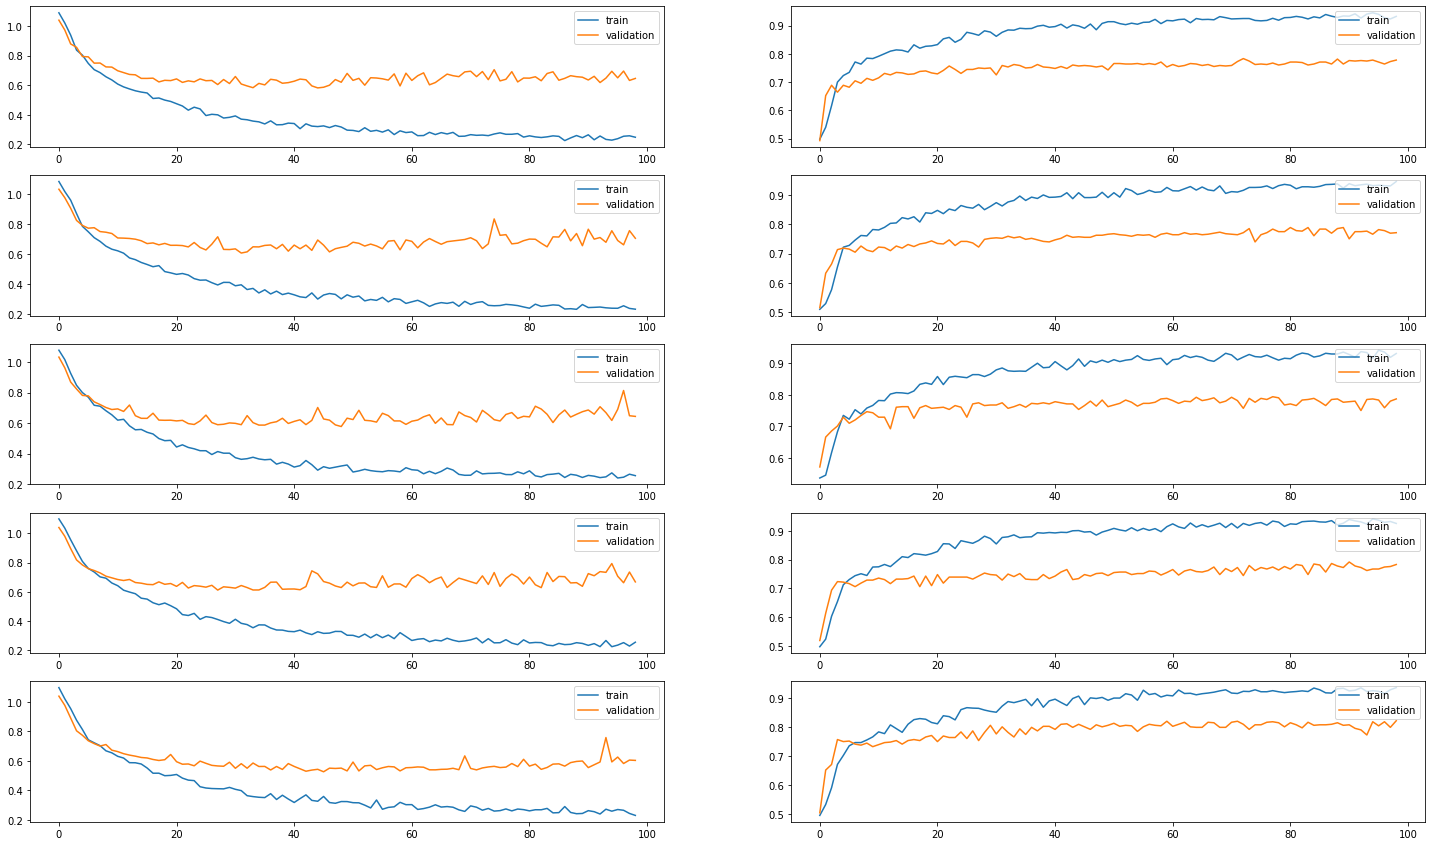

In [15]:
fold_to_show = 0
H = train_history[fold_to_show]

print(H.history.keys())

zoom_start, zoom_end = 0, -1

f, axarr = plt.subplots(len(train_history), 2, figsize=(25, 15))

i=-1
for H in train_history:
    
    i += 1
    
    # "Loss"
    title = 'enc model loss '+str(i)
    axarr[i, 0].plot(H.history['loss'][zoom_start:zoom_end])
    axarr[i, 0].plot(H.history['val_loss'][zoom_start:zoom_end])
#     axarr[i, 0].title(title)
#     axarr[i, 0].ylabel('loss')
#     axarr[i, 0].xlabel('epoch')
    axarr[i, 0].legend(['train', 'validation'], loc='upper right')
#     axarr[i, 0].show()

    # "accuracy"
    title = 'model accuracy '+str(i)
    axarr[i, 1].plot(H.history['accuracy'][zoom_start:zoom_end])
    axarr[i, 1].plot(H.history['val_accuracy'][zoom_start:zoom_end])
#     axarr[i, 1].title(title)
#     axarr[i, 1].ylabel('accuracy')
#     axarr[i, 1].xlabel('epoch')
    axarr[i, 1].legend(['train', 'validation'], loc='upper right')
#     axarr[i, 1].show()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


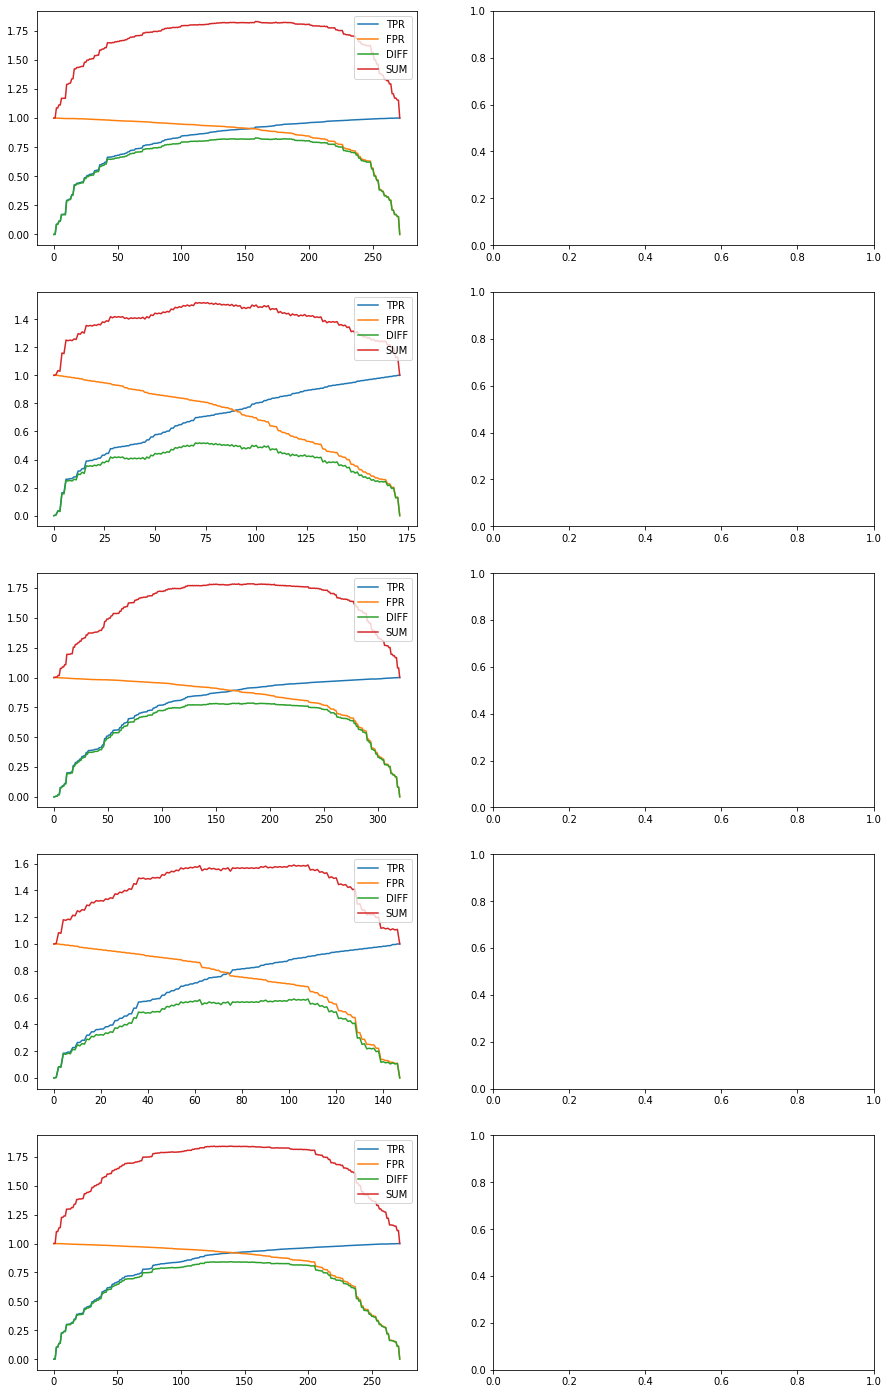

In [16]:
fold_to_show = 0
H = train_history[fold_to_show]

print(H.history.keys())

zoom_start, zoom_end = 0, -1

f, axarr = plt.subplots(len(train_history), 2, figsize=(15, 25))

i=-1
for H in train_history:
    
    i += 1
    
    # "Loss"
    title = 'enc model loss '+str(i)
    axarr[i, 0].plot(evaluations_df['TPR'][i])
    axarr[i, 0].plot(1-evaluations_df['FPR'][i])
    axarr[i, 0].plot(evaluations_df['TPR'][i] - evaluations_df['FPR'][i])
    axarr[i, 0].plot(evaluations_df['TPR'][i] + (1-evaluations_df['FPR'][i]))
    
#     axarr[i, 0].title(title)
#     axarr[i, 0].ylabel('loss')
#     axarr[i, 0].xlabel('epoch')
    axarr[i, 0].legend(['TPR', 'FPR', 'DIFF', 'SUM'], loc='upper right')
#     axarr[i, 0].show()

#     # "accuracy"
#     title = 'model accuracy '+str(i)
#     axarr[i, 1].plot(H.history['accuracy'][zoom_start:zoom_end])
#     axarr[i, 1].plot(H.history['val_accuracy'][zoom_start:zoom_end])
# #     axarr[i, 1].title(title)
# #     axarr[i, 1].ylabel('accuracy')
# #     axarr[i, 1].xlabel('epoch')
#     axarr[i, 1].legend(['train', 'validation'], loc='upper right')
# #     axarr[i, 1].show()

# Independent data

In [17]:
train_features = features
train_labels = labels

In [18]:
##################################################################################
##### read independent data file
##################################################################################
indpe_file_path = os.path.join(input_data_folder, independent_data_file)
indpe_data = pd.read_csv(indpe_file_path, sep='\t', header=None)
indpe_data.columns = ['Sequence', 'name', 'id', 'flag', 'label_original', 'type']
indpe_data.head()
    
##################################################################################
##### Create OHE of sequence
##################################################################################
indpe_data['OHE_Sequence'] = pd.Series([one_hot_encode_nt(val, all_char_dict) 
                                        for val in indpe_data["Sequence"]])

##################################################################################
##### Fix the labels
##################################################################################
indpe_data['label'] = pd.Series([1 if val == 1 else 0 
                                 for val in indpe_data["label_original"]])

##################################################################################
##### Extract features and labels, create folds
##################################################################################

indpe_features = np.array(list(indpe_data['OHE_Sequence']))
indpe_labels = np.array(list(indpe_data['label']))
indpe_labels = indpe_labels.reshape((indpe_labels.shape[0], 1))

input_seq_shape = indpe_features[0].shape

## Using k-fold Models

### Performance of each k-fold model

In [19]:
## create the evaluation data structure for all iterations
indpe_evaluations = {
    "Fold" : [],
    "Train_Test" : [],
    "Accuracy" : [],
    "Precision": [],
    "TPR": [],
    "FPR": [],
    "TPR_FPR_Thresholds": [],
    "AUC": [],
    "Sensitivity": [],
    "Specificity": [],
    "MCC":[]
}

##################################################################################
##### Prediction and metrics for Independent dataset
##################################################################################

for i in range(n_fold):
    
    current_model_path = os.path.join(modelPath, "bestModel-fold{}.hdf5".format(i))
    model = tf.keras.models.load_model(current_model_path)

    y_pred = model.predict(indpe_features)
    label_pred = pred2label(y_pred)

    # Compute precision, recall, sensitivity, specifity, mcc
    acc = accuracy_score(indpe_labels, label_pred)
    prec = precision_score(indpe_labels,label_pred)
    mcc = matthews_corrcoef(indpe_labels, label_pred)

    conf = confusion_matrix(indpe_labels, label_pred)
    tn, fp, fn, tp = conf.ravel()
    sens = tp/(tp+fn)
    spec = tn/(tn+fp)

    fpr, tpr, thresholds = roc_curve(indpe_labels, y_pred)
    auc = roc_auc_score(indpe_labels, y_pred)

    indpe_evaluations["Fold"].append(i)
    indpe_evaluations["Train_Test"].append("Independent")
    indpe_evaluations["Accuracy"].append(acc)
    indpe_evaluations["Precision"].append(prec)
    indpe_evaluations["TPR"].append(tpr)
    indpe_evaluations["FPR"].append(fpr)
    indpe_evaluations["TPR_FPR_Thresholds"].append(thresholds)
    indpe_evaluations["AUC"].append(auc)
    indpe_evaluations["Sensitivity"].append(sens)
    indpe_evaluations["Specificity"].append(spec)
    indpe_evaluations["MCC"].append(mcc)

##################################################################################

indpe_evaluations_df = pd.DataFrame.from_dict(indpe_evaluations)

indpe_evaluations_df_grouped = indpe_evaluations_df.groupby(["Train_Test"]).mean().filter(['Accuracy', 
                                                                               'Precision', 
                                                                               'AUC', 
                                                                               'Sensitivity', 
                                                                               'Specificity', 
                                                                               'MCC'])

indpe_evaluations_df_grouped

,Accuracy,Precision,AUC,Sensitivity,Specificity,MCC
Train_Test,,,,,,
Independent,0.605224,0.239772,0.665335,0.635468,0.599217,0.176112


In [20]:
indpe_evaluations_df

,Fold,Train_Test,Accuracy,Precision,TPR,FPR,TPR_FPR_Thresholds,AUC,Sensitivity,Specificity,MCC
0,0,Independent,0.616327,0.255941,"[0.0, 0.0, 0.0, 0.0049261083743842365, 0.00492...","[0.0, 0.0009784735812133072, 0.001956947162426...","[1.995929, 0.99592894, 0.9957467, 0.99531496, ...",0.677726,0.689655,0.601761,0.217961
1,1,Independent,0.599184,0.238182,"[0.0, 0.0049261083743842365, 0.004926108374384...","[0.0, 0.0, 0.0019569471624266144, 0.0019569471...","[1.9971929, 0.9971929, 0.9951703, 0.99464285, ...",0.663805,0.645320,0.590020,0.175928
2,2,Independent,0.639184,0.245203,"[0.0, 0.0049261083743842365, 0.004926108374384...","[0.0, 0.0, 0.003913894324853229, 0.00391389432...","[1.9998819, 0.99988186, 0.99921346, 0.9990921,...",0.667136,0.566502,0.653620,0.168380
3,3,Independent,0.591020,0.228102,"[0.0, 0.0049261083743842365, 0.004926108374384...","[0.0, 0.0, 0.0019569471624266144, 0.0019569471...","[1.9902792, 0.99027914, 0.98932576, 0.98679763...",0.653288,0.615764,0.586106,0.150959
4,4,Independent,0.580408,0.231434,"[0.0, 0.0049261083743842365, 0.004926108374384...","[0.0, 0.0, 0.0009784735812133072, 0.0009784735...","[1.9986236, 0.9986236, 0.997095, 0.9966929, 0....",0.664721,0.660099,0.564579,0.167332


### Mean score with k-fold models

In [21]:
## create the evaluation data structure for all iterations
indpe_evaluations = {
    "Fold" : [],
    "Train_Test" : [],
    "Accuracy" : [],
    "Precision": [],
    "TPR": [],
    "FPR": [],
    "TPR_FPR_Thresholds": [],
    "AUC": [],
    "Sensitivity": [],
    "Specificity": [],
    "MCC":[]
}

##################################################################################
##### Prediction and metrics for Independent dataset
##################################################################################

total_pred = np.zeros(indpe_labels.shape)
all_preds = []

for i in range(n_fold):
    
    current_model_path = os.path.join(modelPath, "bestModel-fold{}.hdf5".format(i))
    model = tf.keras.models.load_model(current_model_path)

    y_pred = model.predict(indpe_features)
    total_pred += y_pred
    all_preds.append(y_pred)
    
total_pred = total_pred / n_fold
label_pred = pred2label(total_pred)

# Compute precision, recall, sensitivity, specifity, mcc
acc = accuracy_score(indpe_labels, label_pred)
prec = precision_score(indpe_labels,label_pred)
mcc = matthews_corrcoef(indpe_labels, label_pred)

conf = confusion_matrix(indpe_labels, label_pred)
tn, fp, fn, tp = conf.ravel()
sens = tp/(tp+fn)
spec = tn/(tn+fp)

fpr, tpr, thresholds = roc_curve(indpe_labels, total_pred)
auc = roc_auc_score(indpe_labels, total_pred)

indpe_evaluations["Fold"].append(i)
indpe_evaluations["Train_Test"].append("Independent")
indpe_evaluations["Accuracy"].append(acc)
indpe_evaluations["Precision"].append(prec)
indpe_evaluations["TPR"].append(tpr)
indpe_evaluations["FPR"].append(fpr)
indpe_evaluations["TPR_FPR_Thresholds"].append(thresholds)
indpe_evaluations["AUC"].append(auc)
indpe_evaluations["Sensitivity"].append(sens)
indpe_evaluations["Specificity"].append(spec)
indpe_evaluations["MCC"].append(mcc)

##################################################################################

indpe_evaluations_df = pd.DataFrame.from_dict(indpe_evaluations)

indpe_evaluations_df_grouped = indpe_evaluations_df.groupby(["Train_Test"]).mean().filter(['Accuracy', 
                                                                               'Precision', 
                                                                               'AUC', 
                                                                               'Sensitivity', 
                                                                               'Specificity', 
                                                                               'MCC'])

indpe_evaluations_df_grouped

,Accuracy,Precision,AUC,Sensitivity,Specificity,MCC
Train_Test,,,,,,
Independent,0.610612,0.248162,0.679369,0.665025,0.599804,0.198183


In [22]:
indpe_evaluations_df

,Fold,Train_Test,Accuracy,Precision,TPR,FPR,TPR_FPR_Thresholds,AUC,Sensitivity,Specificity,MCC
0,4,Independent,0.610612,0.248162,"[0.0, 0.0049261083743842365, 0.004926108374384...","[0.0, 0.0, 0.003913894324853229, 0.00391389432...","[1.9962584972381592, 0.9962584972381592, 0.991...",0.679369,0.665025,0.599804,0.198183


### Voting score with k-fold models

In [23]:
## create the evaluation data structure for all iterations
indpe_evaluations = {
    "Train_Test" : [],
    "Accuracy" : [],
    "Precision": [],
    "TPR": [],
    "FPR": [],
    "TPR_FPR_Thresholds": [],
    "AUC": [],
    "Sensitivity": [],
    "Specificity": [],
    "MCC":[]
}

##################################################################################
##### Prediction and metrics for Independent dataset
##################################################################################

total_pred = np.zeros(indpe_labels.shape)
all_preds = []

for i in range(n_fold):
    
    current_model_path = os.path.join(modelPath, "bestModel-fold{}.hdf5".format(i))
    model = tf.keras.models.load_model(current_model_path)

    y_pred = model.predict(indpe_features)
    vote_pred = pred2label(y_pred)
    total_pred += vote_pred
    all_preds.append(vote_pred)
    
total_pred = total_pred / n_fold
label_pred = pred2label(total_pred)

# Compute precision, recall, sensitivity, specifity, mcc
acc = accuracy_score(indpe_labels, label_pred)
prec = precision_score(indpe_labels,label_pred)
mcc = matthews_corrcoef(indpe_labels, label_pred)

conf = confusion_matrix(indpe_labels, label_pred)
tn, fp, fn, tp = conf.ravel()
sens = tp/(tp+fn)
spec = tn/(tn+fp)

fpr, tpr, thresholds = roc_curve(indpe_labels, total_pred)
auc = roc_auc_score(indpe_labels, total_pred)

indpe_evaluations["Train_Test"].append("Independent")
indpe_evaluations["Accuracy"].append(acc)
indpe_evaluations["Precision"].append(prec)
indpe_evaluations["TPR"].append(tpr)
indpe_evaluations["FPR"].append(fpr)
indpe_evaluations["TPR_FPR_Thresholds"].append(thresholds)
indpe_evaluations["AUC"].append(auc)
indpe_evaluations["Sensitivity"].append(sens)
indpe_evaluations["Specificity"].append(spec)
indpe_evaluations["MCC"].append(mcc)

##################################################################################

indpe_evaluations_df = pd.DataFrame.from_dict(indpe_evaluations)

indpe_evaluations_df_grouped = indpe_evaluations_df.groupby(["Train_Test"]).mean().filter(['Accuracy', 
                                                                               'Precision', 
                                                                               'AUC', 
                                                                               'Sensitivity', 
                                                                               'Specificity', 
                                                                               'MCC'])

indpe_evaluations_df_grouped

,Accuracy,Precision,AUC,Sensitivity,Specificity,MCC
Train_Test,,,,,,
Independent,0.612245,0.246269,0.661094,0.650246,0.604697,0.191084


In [24]:
indpe_evaluations_df

,Train_Test,Accuracy,Precision,TPR,FPR,TPR_FPR_Thresholds,AUC,Sensitivity,Specificity,MCC
0,Independent,0.612245,0.246269,"[0.0, 0.42857142857142855, 0.5467980295566502,...","[0.0, 0.19863013698630136, 0.30332681017612523...","[2.0, 1.0, 0.8, 0.6, 0.4, 0.2, 0.0]",0.661094,0.650246,0.604697,0.191084


## Using New Model

Train model on full data from training. Predict and evaluate on Independent data.

In [25]:
pos_indexes = np.where(indpe_labels==1)[0]
neg_indexes = np.random.permutation(np.where(indpe_labels==0)[0])[0:pos_indexes.shape[0]]
indpe_val_indexes = np.concatenate((pos_indexes, neg_indexes))

In [26]:
model = DLNN_CORENup(input_seq_shape = input_seq_shape)
    
## Define the model callbacks for early stopping and saving the model. Then train model
current_model_path = os.path.join(modelPath, "_fullModel.hdf5")
modelCallbacks = [
    tf.keras.callbacks.ModelCheckpoint(current_model_path,
                                       monitor = monitor, verbose = 1, save_best_only = True, 
                                       save_weights_only = False, mode = 'auto', save_freq = 'epoch'),
]

# adding random shuffling of the dataset for training purpose
index_arr = np.arange(train_features.shape[0])
index_arr = np.random.permutation(index_arr)

# H = model.fit(x = train_features[index_arr], y = train_labels[index_arr], 
#                     batch_size = batch_size, epochs = epochs, 
#                     verbose = 1, callbacks = modelCallbacks, 
#                     validation_data = (indpe_features[indpe_val_indexes], indpe_labels[indpe_val_indexes]))
# H = model.fit(x = train_features[index_arr], y = train_labels[index_arr], 
#                     batch_size = batch_size, epochs = epochs, 
#                     verbose = 1, callbacks = modelCallbacks, 
#                     validation_data = (indpe_features, indpe_labels))
model.fit(x = train_features[index_arr], y = train_labels[index_arr], 
          batch_size = batch_size, epochs = epochs, verbose = 1, 
          callbacks = modelCallbacks, 
          validation_split = valsplit)

model = tf.keras.models.load_model(current_model_path)

Epoch 1/100
105/105 [==============================] - ETA: 0s - loss: 1.0785 - accuracy: 0.5153
Epoch 1: val_loss improved from inf to 1.01541, saving model to Results\NT_Site_PredNTS_Classification_DLNN_CORENup_v2_gaussianNoise_valsplit\5fold\models\_fullModel.hdf5
105/105 [==============================] - 4s 18ms/step - loss: 1.0785 - accuracy: 0.5153 - val_loss: 1.0154 - val_accuracy: 0.6042
Epoch 2/100
101/105 [===========================>..] - ETA: 0s - loss: 0.9863 - accuracy: 0.5916
Epoch 2: val_loss improved from 1.01541 to 0.87165, saving model to Results\NT_Site_PredNTS_Classification_DLNN_CORENup_v2_gaussianNoise_valsplit\5fold\models\_fullModel.hdf5
105/105 [==============================] - 1s 11ms/step - loss: 0.9834 - accuracy: 0.5927 - val_loss: 0.8717 - val_accuracy: 0.7245
Epoch 3/100
101/105 [===========================>..] - ETA: 0s - loss: 0.8842 - accuracy: 0.6856
Epoch 3: val_loss improved from 0.87165 to 0.81340, saving model to Results\NT_Site_PredNTS_Classif

Epoch 22/100
104/105 [============================>.] - ETA: 0s - loss: 0.4639 - accuracy: 0.8383
Epoch 22: val_loss did not improve from 0.54764
105/105 [==============================] - 1s 11ms/step - loss: 0.4635 - accuracy: 0.8386 - val_loss: 0.5549 - val_accuracy: 0.7636
Epoch 23/100
101/105 [===========================>..] - ETA: 0s - loss: 0.4771 - accuracy: 0.8274
Epoch 23: val_loss did not improve from 0.54764
105/105 [==============================] - 1s 10ms/step - loss: 0.4780 - accuracy: 0.8272 - val_loss: 0.5652 - val_accuracy: 0.7552
Epoch 24/100
104/105 [============================>.] - ETA: 0s - loss: 0.4559 - accuracy: 0.8450
Epoch 24: val_loss improved from 0.54764 to 0.53665, saving model to Results\NT_Site_PredNTS_Classification_DLNN_CORENup_v2_gaussianNoise_valsplit\5fold\models\_fullModel.hdf5
105/105 [==============================] - 1s 11ms/step - loss: 0.4554 - accuracy: 0.8452 - val_loss: 0.5367 - val_accuracy: 0.7650
Epoch 25/100
104/105 [================

 99/105 [===========================>..] - ETA: 0s - loss: 0.3470 - accuracy: 0.8870
Epoch 49: val_loss did not improve from 0.50919
105/105 [==============================] - 1s 10ms/step - loss: 0.3468 - accuracy: 0.8848 - val_loss: 0.5151 - val_accuracy: 0.7958
Epoch 50/100
 99/105 [===========================>..] - ETA: 0s - loss: 0.3379 - accuracy: 0.8908
Epoch 50: val_loss did not improve from 0.50919
105/105 [==============================] - 1s 10ms/step - loss: 0.3364 - accuracy: 0.8920 - val_loss: 0.5553 - val_accuracy: 0.7804
Epoch 51/100
105/105 [==============================] - ETA: 0s - loss: 0.3096 - accuracy: 0.9088
Epoch 51: val_loss did not improve from 0.50919
105/105 [==============================] - 1s 10ms/step - loss: 0.3096 - accuracy: 0.9088 - val_loss: 0.5430 - val_accuracy: 0.7804
Epoch 52/100
105/105 [==============================] - ETA: 0s - loss: 0.3202 - accuracy: 0.8986
Epoch 52: val_loss did not improve from 0.50919
105/105 [========================

105/105 [==============================] - 1s 11ms/step - loss: 0.2942 - accuracy: 0.9136 - val_loss: 0.5554 - val_accuracy: 0.7930
Epoch 79/100
100/105 [===========================>..] - ETA: 0s - loss: 0.2991 - accuracy: 0.9062
Epoch 79: val_loss did not improve from 0.50919
105/105 [==============================] - 1s 11ms/step - loss: 0.2962 - accuracy: 0.9070 - val_loss: 0.5610 - val_accuracy: 0.7930
Epoch 80/100
104/105 [============================>.] - ETA: 0s - loss: 0.3018 - accuracy: 0.9099
Epoch 80: val_loss did not improve from 0.50919
105/105 [==============================] - 1s 11ms/step - loss: 0.3024 - accuracy: 0.9094 - val_loss: 0.5496 - val_accuracy: 0.7986
Epoch 81/100
105/105 [==============================] - ETA: 0s - loss: 0.2795 - accuracy: 0.9172
Epoch 81: val_loss did not improve from 0.50919
105/105 [==============================] - 1s 11ms/step - loss: 0.2795 - accuracy: 0.9172 - val_loss: 0.5452 - val_accuracy: 0.8028
Epoch 82/100
104/105 [============

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


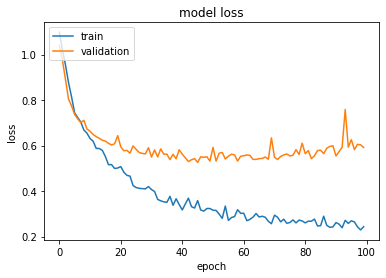

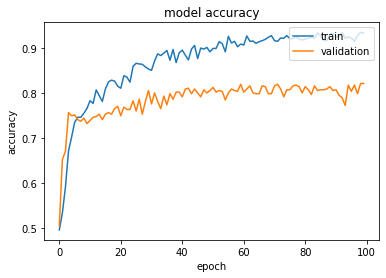

In [27]:
print(H.history.keys())

# "Loss"
plt.plot(H.history['loss'])
plt.plot(H.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

# "accuracy"
plt.plot(H.history['accuracy'])
plt.plot(H.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper right')
plt.show()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


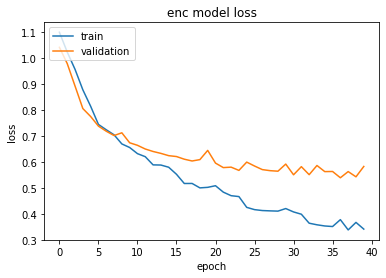

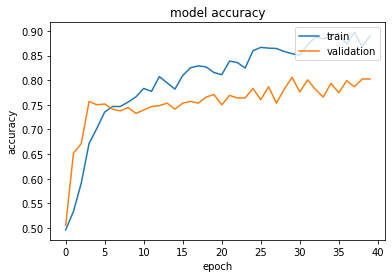

In [28]:
print(H.history.keys())

zoom_start, zoom_end = 0, 40

# "Loss"
plt.plot(H.history['loss'][zoom_start:zoom_end])
plt.plot(H.history['val_loss'][zoom_start:zoom_end])
plt.title('enc model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

# "accuracy"
plt.plot(H.history['accuracy'][zoom_start:zoom_end])
plt.plot(H.history['val_accuracy'][zoom_start:zoom_end])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper right')
plt.show()

In [29]:
## create the evaluation data structure for all iterations
indpe_evaluations = {
    "Train_Test" : [],
    "Accuracy" : [],
    "Precision": [],
    "TPR": [],
    "FPR": [],
    "TPR_FPR_Thresholds": [],
    "AUC": [],
    "Sensitivity": [],
    "Specificity": [],
    "MCC":[]
}

##################################################################################
##### Prediction and metrics for Independent dataset
##################################################################################

y_pred = model.predict(indpe_features)
label_pred = pred2label(y_pred)

# Compute precision, recall, sensitivity, specifity, mcc
acc = accuracy_score(indpe_labels, label_pred)
prec = precision_score(indpe_labels,label_pred)
mcc = matthews_corrcoef(indpe_labels, label_pred)

conf = confusion_matrix(indpe_labels, label_pred)
tn, fp, fn, tp = conf.ravel()
sens = tp/(tp+fn)
spec = tn/(tn+fp)

fpr, tpr, thresholds = roc_curve(indpe_labels, y_pred)
auc = roc_auc_score(indpe_labels, y_pred)

indpe_evaluations["Train_Test"].append("Independent")
indpe_evaluations["Accuracy"].append(acc)
indpe_evaluations["Precision"].append(prec)
indpe_evaluations["TPR"].append(tpr)
indpe_evaluations["FPR"].append(fpr)
indpe_evaluations["TPR_FPR_Thresholds"].append(thresholds)
indpe_evaluations["AUC"].append(auc)
indpe_evaluations["Sensitivity"].append(sens)
indpe_evaluations["Specificity"].append(spec)
indpe_evaluations["MCC"].append(mcc)

##################################################################################

indpe_evaluations_df = pd.DataFrame.from_dict(indpe_evaluations)

indpe_evaluations_df_grouped = indpe_evaluations_df.groupby(["Train_Test"]).mean().filter(['Accuracy', 
                                                                               'Precision', 
                                                                               'AUC', 
                                                                               'Sensitivity', 
                                                                               'Specificity', 
                                                                               'MCC'])

indpe_evaluations_df_grouped

,Accuracy,Precision,AUC,Sensitivity,Specificity,MCC
Train_Test,,,,,,
Independent,0.654694,0.262931,0.685577,0.600985,0.665362,0.20416


In [ ]:
# val split 0.3
	Accuracy	Precision	AUC	Sensitivity	Specificity	MCC
Train_Test						
Independent	0.654694	0.262931	0.685577	0.600985	0.665362	0.20416

In [30]:
# val split 0.2
# 	Accuracy	Precision	AUC	Sensitivity	Specificity	MCC
# Train_Test						
# Independent	0.631837	0.246939	0.669069	0.596059	0.638943	0.178363